# Introduction to the pycox package


In this notebook we introduce the use of `pycox` through an example dataset.
We illustrate the procedure with the `LogisticHazard` method ([paper_link](https://arxiv.org/abs/1910.06724)), but we this can easily be replaced by for example `PMF`, `MTLR` or `DeepHitSingle`.

In the following we will:

- Load the METABRIC survival dataset.
- Process the event labels so the they work with our methods.
- Create a [PyTorch](https://pytorch.org) neural network.
- Fit the model.
- Evaluate the predictive performance using the concordance, Brier score, and negative binomial log-likelihood.

While some knowledge of the [PyTorch](https://pytorch.org) framework is preferable, it is not required for the use of simple neural networks.
For building more advanced network architectures, however, we would recommend looking at [the PyTorch tutorials](https://pytorch.org/tutorials/).

## Imports

You need `sklearn-pandas` which can be installed by uncommenting the following block

In [130]:
# ! pip install sklearn-pandas

In [131]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lifelines.utils import concordance_index

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

`pycox` is built on top of [PyTorch](https://pytorch.org) and [torchtuples](https://github.com/havakv/torchtuples), where the latter is just a simple way of training neural nets with less boilerplate code.

In [132]:
import torch # For building the networks 
import torchtuples as tt # Some useful functions

We import the `metabric` dataset, the `LogisticHazard` method ([paper_link](https://arxiv.org/abs/1910.06724)) also known as [Nnet-survival](https://peerj.com/articles/6257/), and `EvalSurv` which simplifies the evaluation procedure at the end.

You can alternatively replace `LogisticHazard` with, for example, `PMF` or `DeepHitSingle`, which should both work in this notebook.

In [133]:
# from pycox.datasets import metabric
# from pycox.models import LogisticHazard
# from pycox.models import PMF
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [134]:
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [135]:
# Paths to your folders
toas_folder = './toas'
training_folder = './gog_features/training'

# Initialize lists to store data
features_list = []
durations_list = []
events_list = []

# Specify the keys for the features
feature_keys = ['graph_level_feat', 'image_feat', 'frame_level_feat']
FPS = 10  # Frames per second (change if needed)

# Initialize dictionaries to store feature sizes
feature_sizes = {key: 0 for key in feature_keys}
total_samples = 0
event_ocurred = 0
event_not_ocurred = 0

# Process each .npz file in the training folder
for npz_file in os.listdir(training_folder):
    if npz_file.endswith('.npz'):
        file_id = os.path.splitext(npz_file)[0]
        npz_path = os.path.join(training_folder, npz_file)
        
        # Load feature data from .npz file
        npz_data = np.load(npz_path)

        # Initialize a list to hold the combined features for this file
        combined_features = []

        # Concatenate features from each specified key
        for key in feature_keys:
            if key in npz_data:
                features = npz_data[key].flatten()  # Flatten if the feature array has more than one dimension
                combined_features.extend(features)  # Add to combined feature list
                feature_sizes[key] += len(features)  # Accumulate feature size
            else:
                continue

        if combined_features:
            features_list.append(combined_features)  # Append combined features to main list
            total_samples += 1

            # Check if corresponding .txt file exists in the "toas" folder
            txt_path = os.path.join(toas_folder, f"{file_id}.txt")
            if os.path.exists(txt_path):
                # Load frame count from the .txt file and convert to seconds
                with open(txt_path, 'r') as f:
                    frame_count = float(f.read().strip())
                duration = frame_count / FPS  # Convert frames to seconds
                event = 1  # Event occurred
                event_ocurred += 1
            else:
                # Assign random duration for censored data
                duration = 5
                event = 0  # Censored event
                event_not_ocurred += 1

            durations_list.append(duration)
            events_list.append(event)

# Compute total dataset size
num_features = len(features_list[0]) if features_list else 0

# Display feature sizes and dataset size
print("Feature Sizes:")
for key, size in feature_sizes.items():
    print(f"  {key}: {size // total_samples} (per sample)")

print(f"Total features per sample: {num_features}")
print(f"Total dataset size: {total_samples} samples, {num_features} features per sample")



# Convert to DataFrame for convenience
num_features = len(features_list[0]) if features_list else 0
data = pd.DataFrame(features_list, columns=[f'x{i}' for i in range(num_features)])
data['duration'] = durations_list
data['event'] = events_list

# Split dataset into train, test, and validation sets
df_test = data.sample(frac=0.2, random_state=42)  # 20% for testing
df_train = data.drop(df_test.index)  # Remaining 80% for training
df_val = df_train.sample(frac=0.2, random_state=42)  # 20% of train for validation
df_train = df_train.drop(df_val.index)  # Remaining 80% of original train for training

# # Standardize the feature columns
# scaler = StandardScaler()
# train_features = scaler.fit_transform(df_train.drop(columns=['duration', 'event']))
# val_features = scaler.transform(df_val.drop(columns=['duration', 'event']))
# test_features = scaler.transform(df_test.drop(columns=['duration', 'event']))

# # Convert to PyTorch tensors
# X_train = torch.tensor(train_features, dtype=torch.float32)
# y_train_duration = torch.tensor(df_train['duration'].values, dtype=torch.float32)
# y_train_event = torch.tensor(df_train['event'].values, dtype=torch.float32)

# X_val = torch.tensor(val_features, dtype=torch.float32)
# y_val_duration = torch.tensor(df_val['duration'].values, dtype=torch.float32)
# y_val_event = torch.tensor(df_val['event'].values, dtype=torch.float32)

# X_test = torch.tensor(test_features, dtype=torch.float32)
# y_test_duration = torch.tensor(df_test['duration'].values, dtype=torch.float32)
# y_test_event = torch.tensor(df_test['event'].values, dtype=torch.float32)

# Check data shapes
print("Training data shape:", df_train.shape)
print("Validation data shape:", df_val.shape)
print("Test data shape:", df_test.shape)

print(event_ocurred, event_not_ocurred)

Feature Sizes:
  graph_level_feat: 12800 (per sample)
  image_feat: 25600 (per sample)
  frame_level_feat: 6400 (per sample)
Total features per sample: 44800
Total dataset size: 4288 samples, 44800 features per sample
Training data shape: (2744, 44802)
Validation data shape: (686, 44802)
Test data shape: (858, 44802)
3679 609


In [136]:
print(df_train.head())
print(df_test.head())
print(df_val.head())

         x0        x1        x2        x3        x4        x5        x6  \
1 -0.030687  4.421785 -0.034889 -0.035512  4.583477  7.180857  4.849174   
2  0.125156  1.185009  0.015235  1.195709  1.063940  1.791380  2.647510   
3 -0.065673  4.020284 -0.066604 -0.057531  5.214034  5.565491  5.937151   
4 -0.300407  2.598834 -0.305906 -0.095251  1.441667  3.046954  2.021150   
5 -0.097951  3.401984 -0.134391  1.382059  2.174992  2.510055  2.047488   

         x7        x8        x9  ...    x44792    x44793    x44794    x44795  \
1  6.775678  3.403293  0.563559  ...  0.199240  0.042133 -0.043475  0.985201   
2  1.217420  1.064873  1.363487  ...  0.169658  0.034465 -0.056265  0.108986   
3  4.037354  3.167806  2.598907  ... -0.008388  0.233198 -0.210051  0.138436   
4  1.827749  1.619585  0.862362  ...  0.944927  0.127547 -0.185528 -0.084196   
5  2.004014  2.719052  1.510656  ...  0.712301  0.747527 -0.054564  0.727746   

     x44796    x44797    x44798    x44799  duration  event  
1  0.49

## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

Here we use the `sklearn_pandas.DataFrameMapper` to make feature mappers, but this has nothing to do the the `pycox` package.

In [137]:
cols_standardize = [f'x{i}' for i in range(44800)]  
cols_leave = []  

# Create standardization transformations for all features
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

# Initialize DataFrameMapper with standardization applied to all features
x_mapper = DataFrameMapper(standardize + leave)

In [138]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
For most of them the `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

The `LogisticHazard` is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

In [139]:
num_durations = 50  # Number of intervals (50 parts)

# Define custom cuts for a fixed 5-second interval divided into 50 parts
custom_cuts = np.linspace(0, 5, num=num_durations+1)  # 50 intervals within the 5-second range

# Use custom cuts with LogisticHazard
# labtrans = LogisticHazard.label_transform(cuts=custom_cuts)
# labtrans = PMF.label_transform(num_durations)
labtrans = DeepHitSingle.label_transform(cuts=custom_cuts)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

c:\Users\kavin\miniconda3\envs\pycox\lib\site-packages\pycox\preprocessing\label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


In [140]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

The `labtrans.cuts` contains the discretization grid. This will later be used to obtain the right time-scale for survival predictions.

In [141]:
labtrans.cuts

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

Now, `y_train` is a tuple with the indices of the discretized times, in addition to event indicators.

In [142]:
y_train

(array([40, 40, 40, ..., 50, 17, 50], dtype=int64),
 array([1., 1., 1., ..., 0., 1., 0.], dtype=float32))

In [143]:
labtrans.cuts[y_train[0]]

array([4. , 4. , 4. , ..., 5. , 1.7, 5. ])

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `out_features` output nodes.
We also have batch normalization and dropout between the layers.

In [144]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

If you instead want to build this network with `torch` you can uncomment the following code.
It is essentially equivalent to the `MLPVanilla`, but without the `torch.nn.init.kaiming_normal_` weight initialization.

In [145]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, out_features)
# )

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, or use one from `tt.optim`.
The latter is built on top of the `torch` optimizers, but with some added functionality (such as not requiring `net.parameters()` as input and the `model.lr_finder` for finding suitable learning rates).
We will here use the `Adam` optimizer with learning rate 0.01.

We also set `duration_index` which connects the output nodes of the network the the discretization times. This is only useful for prediction and does not affect the training procedure.

The `LogisticHazard` can also take the argument `device` which can be use to choose between running on the CPU and GPU. The default behavior is to run on a GPU if it is available, and CPU if not.
See `?LogisticHazard` for details.

In [146]:
# model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

Next, we set the `batch_size` and the number of training `epochs`.

We also include the `EarlyStopping` callback to stop training when the validation loss stops improving.

In [147]:
batch_size = 150
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

We can now train the network and the `log` object keeps track of the training progress.

In [148]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.1145,	val_loss: 1.0792
1:	[0s / 1s],		train_loss: 0.9746,	val_loss: 0.9603
2:	[0s / 1s],		train_loss: 0.9000,	val_loss: 0.9121
3:	[0s / 2s],		train_loss: 0.8629,	val_loss: 0.8670
4:	[0s / 2s],		train_loss: 0.8158,	val_loss: 0.8488
5:	[0s / 3s],		train_loss: 0.7888,	val_loss: 0.8332
6:	[0s / 3s],		train_loss: 0.7542,	val_loss: 0.8211
7:	[0s / 4s],		train_loss: 0.7203,	val_loss: 0.8284
8:	[0s / 4s],		train_loss: 0.6978,	val_loss: 0.8788
9:	[0s / 5s],		train_loss: 0.6877,	val_loss: 1.0651
10:	[0s / 5s],		train_loss: 0.7052,	val_loss: 0.8842
11:	[0s / 6s],		train_loss: 0.6762,	val_loss: 0.9747
12:	[0s / 6s],		train_loss: 0.6362,	val_loss: 1.0226
13:	[0s / 7s],		train_loss: 0.6045,	val_loss: 1.2791
14:	[0s / 7s],		train_loss: 0.5831,	val_loss: 1.3940
15:	[0s / 8s],		train_loss: 0.5515,	val_loss: 1.5298
16:	[0s / 8s],		train_loss: 0.5527,	val_loss: 1.6361


c:\Users\kavin\miniconda3\envs\pycox\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwa

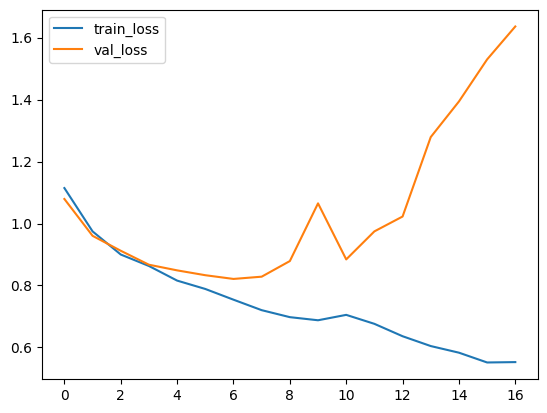

In [149]:
_ = log.plot()

After termination, the `EarlyStopping` callback loads the best performing model (in terms of validation loss).
We can verify this by comparing the minimum validation loss to the validation score of the trained `model`.

In [150]:
log.to_pandas().val_loss.min()

0.8211252689361572

In [151]:
model.score_in_batches(val)

{'loss': 0.8211252689361572}

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [152]:
surv = model.predict_surv_df(x_test)

Mean difference in predicted and true times: -0.0487 seconds
Mean Absolute Error (MAE): 0.6671 seconds
Mean Squared Error (MSE): 0.7501 seconds^2
C-index: 0.3022


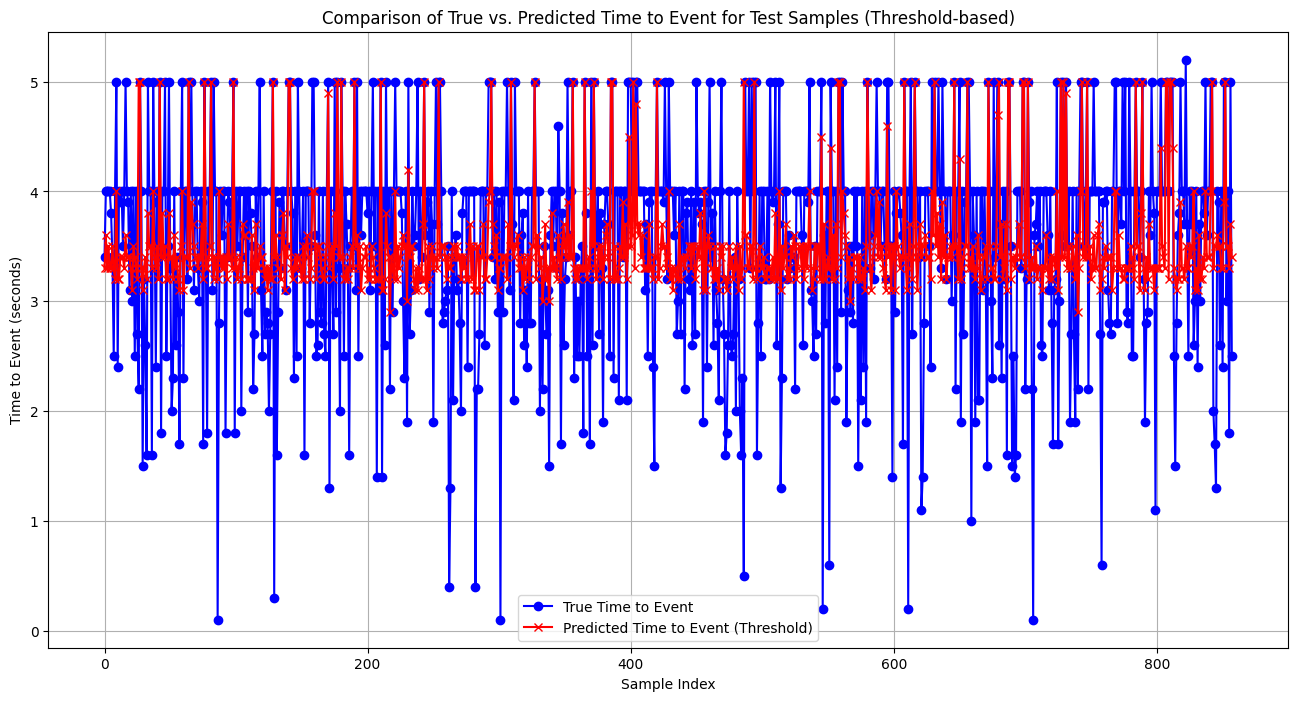

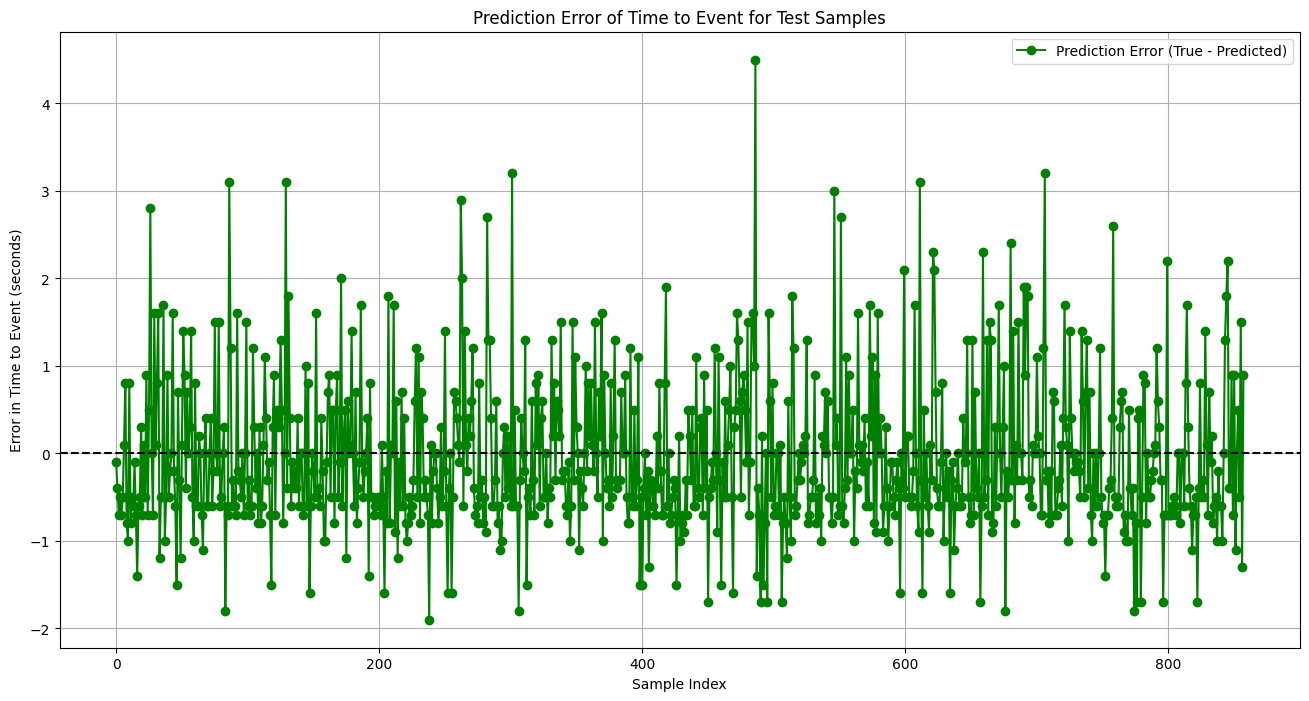

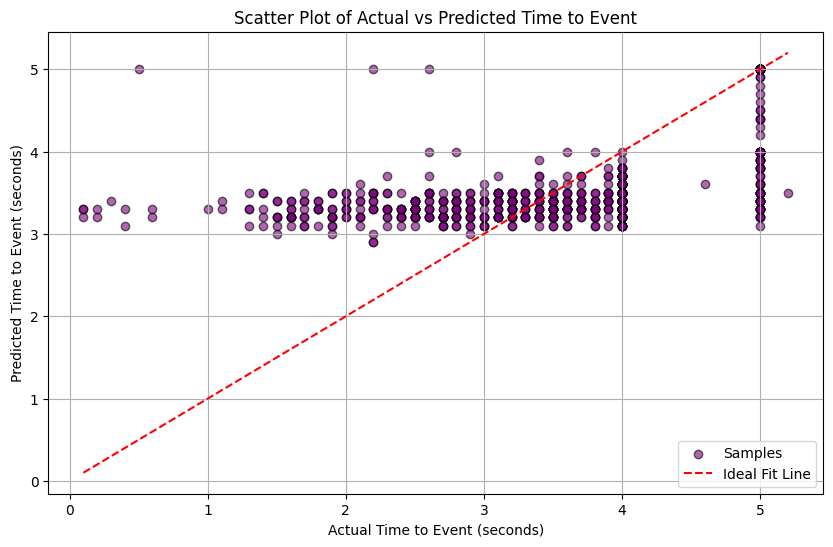

Correlation Coefficient between predicted and actual times: 0.4956


In [153]:
# Predict the survival functions for the test data
surv_test = model.predict_surv_df(x_test)
true_times_test = y_test_duration.numpy()

# Get predicted times by finding the first time when survival probability drops below 0.5
threshold = 0.5
predicted_times_test = []
for col in surv_test.columns:
    time_to_event = surv_test[surv_test[col] < threshold].index[0] if (surv_test[col] < threshold).any() else surv_test.index[-1]
    predicted_times_test.append(time_to_event)

# Convert list to a numpy array for easier calculations
predicted_times_test = np.array(predicted_times_test)

# Calculate the difference between the predicted and true times
time_diff = predicted_times_test - true_times_test
print(f"Mean difference in predicted and true times: {time_diff.mean():.4f} seconds")

# 1. Mean Absolute Error (MAE)
mae = np.abs(predicted_times_test - true_times_test).mean()
print(f"Mean Absolute Error (MAE): {mae:.4f} seconds")

# 2. Mean Squared Error (MSE)
mse = np.square(predicted_times_test - true_times_test).mean()
print(f"Mean Squared Error (MSE): {mse:.4f} seconds^2")

# 3. C-index (Concordance Index)
c_index = concordance_index(true_times_test, -predicted_times_test)  # negative because we want higher times to be better
print(f"C-index: {c_index:.4f}")

# Plot to compare with true times
plt.figure(figsize=(16, 8))
plt.plot(range(len(true_times_test)), true_times_test, label='True Time to Event', color='blue', marker='o')
plt.plot(range(len(predicted_times_test)), predicted_times_test, label='Predicted Time to Event (Threshold)', color='red', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Time to Event (seconds)')
plt.legend()
plt.title('Comparison of True vs. Predicted Time to Event for Test Samples (Threshold-based)')
plt.grid(True)
plt.show()

# Plot the error between true and predicted times
plt.figure(figsize=(16, 8))
plt.plot(range(len(time_diff)), time_diff, label='Prediction Error (True - Predicted)', color='green', marker='o')
plt.axhline(0, color='black', linestyle='--')  # Zero error line
plt.xlabel('Sample Index')
plt.ylabel('Error in Time to Event (seconds)')
plt.legend()
plt.title('Prediction Error of Time to Event for Test Samples')
plt.grid(True)
plt.show()

# Scatter plot to compare actual and predicted time-to-event values
plt.figure(figsize=(10, 6))
plt.scatter(true_times_test, predicted_times_test, color='purple', alpha=0.6, edgecolor='k', label='Samples')
plt.plot([true_times_test.min(), true_times_test.max()], [true_times_test.min(), true_times_test.max()], 'r--', label='Ideal Fit Line')  # 45-degree line
plt.xlabel('Actual Time to Event (seconds)')
plt.ylabel('Predicted Time to Event (seconds)')
plt.legend()
plt.title('Scatter Plot of Actual vs Predicted Time to Event')
plt.grid(True)
plt.show()

# Compute the correlation coefficient
correlation_coefficient = np.corrcoef(true_times_test, predicted_times_test)[0, 1]
print(f"Correlation Coefficient between predicted and actual times: {correlation_coefficient:.4f}")


We can plot the survival estimates for the first 5 individuals.
Note that the time scale is correct because we have set `model.duration_index` to be the grid points.
We have, however, only defined the survival estimates at the 10 times in our discretization grid, so, the survival estimates is a step function

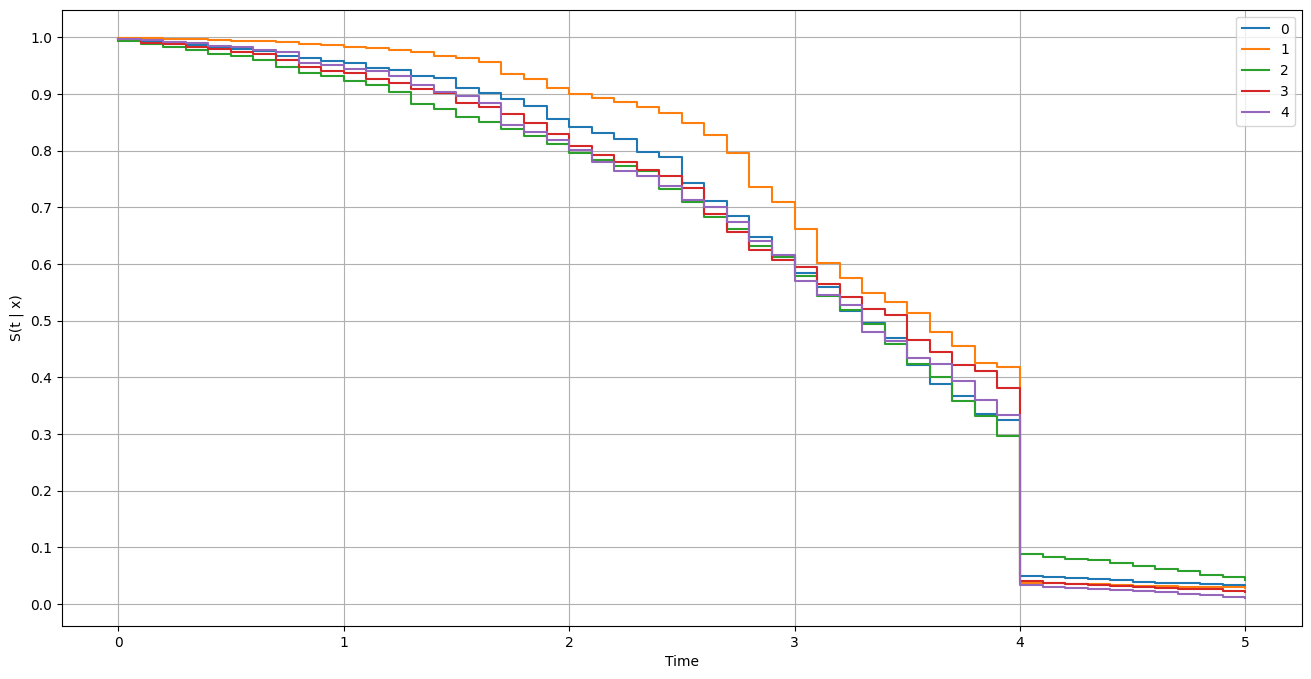

In [154]:
ax = surv.iloc[:, :5].plot(drawstyle='steps-post', figsize=(16, 8))
plt.ylabel('S(t | x)')
plt.xlabel('Time')
plt.grid(True)
plt.yticks([i / 10 for i in range(11)])
# plt.yticks([i / 100 for i in range(101)])
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.2f}'.format(val)))
plt.show()

It is, therefore, often beneficial to [interpolate the survival estimates](https://arxiv.org/abs/1910.06724).
Linear interpolation (constant density interpolation) can be performed with the `interpolate` method. We also need to choose how many points we want to replace each grid point with. Her we will use 10.

In [155]:
surv = model.interpolate(50).predict_surv_df(x_test)

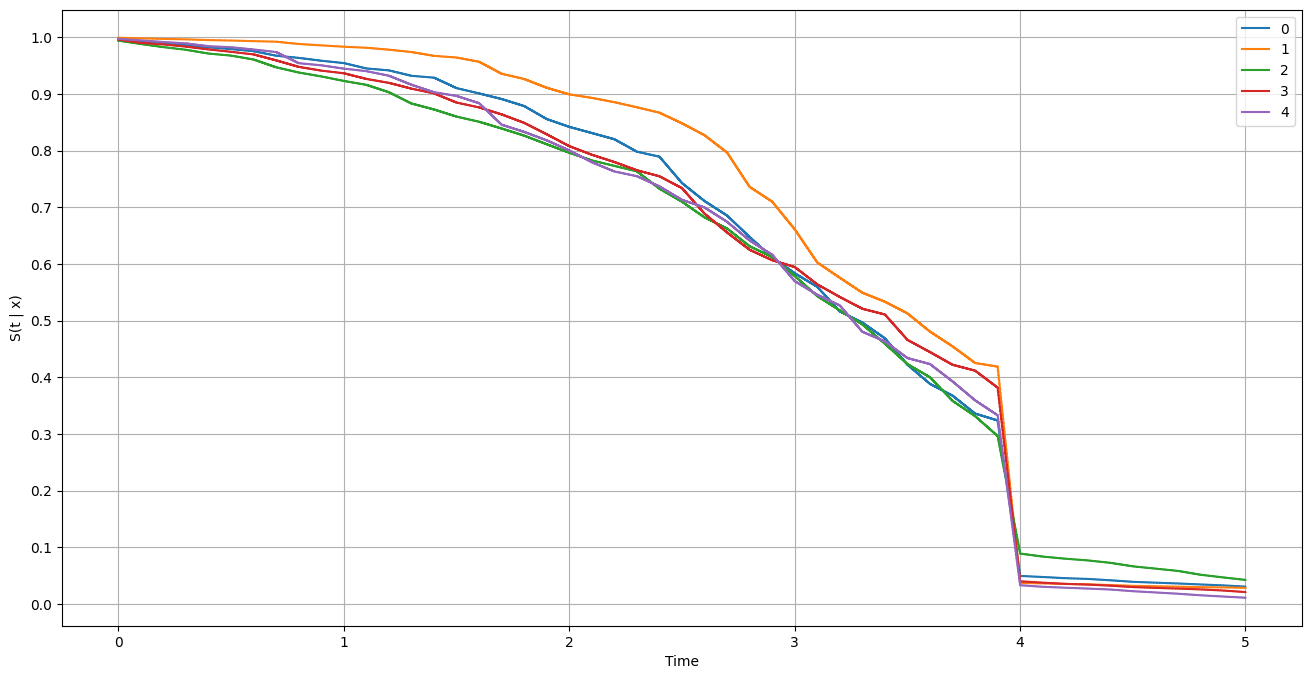

In [156]:
ax = surv.iloc[:, :5].plot(drawstyle='steps-post', figsize=(16, 8))
plt.ylabel('S(t | x)')
plt.xlabel('Time')
plt.grid(True)
plt.yticks([i / 10 for i in range(11)])
# plt.yticks([i / 100 for i in range(101)])
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.2f}'.format(val)))
plt.show()

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [157]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [158]:
ev.concordance_td('antolini')

0.7324204980965687

#### Brier Score

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times.
Here we just use 100 time-points between the min and max duration in the test set.
Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

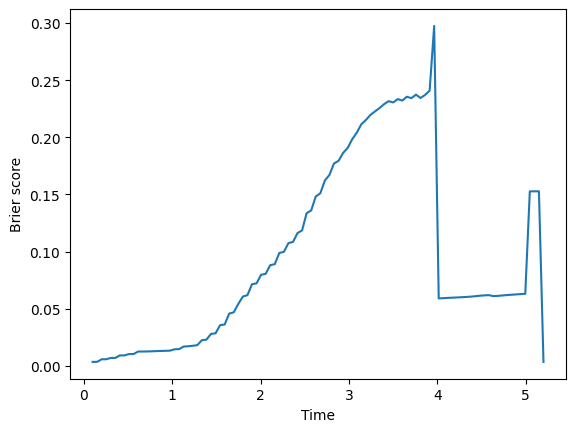

In [159]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

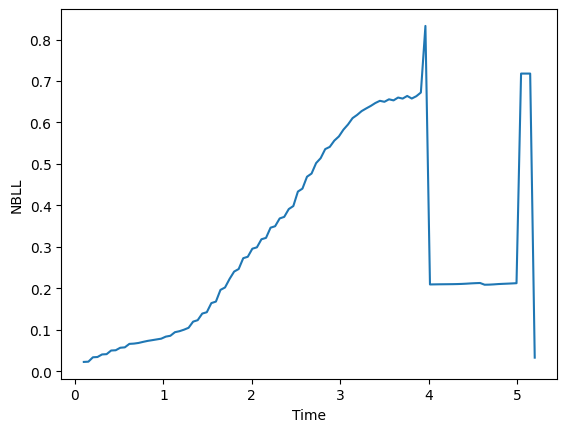

In [160]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [161]:
ev.integrated_brier_score(time_grid) 

0.09681236019852789

In [162]:
ev.integrated_nbll(time_grid) 

0.3173541327965785

# Next

You can now look at other examples of survival methods in the [examples folder](https://nbviewer.jupyter.org/github/havakv/pycox/tree/master/examples).
Or, alternatively take a look at

- the more advanced training procedures in the notebook [02_introduction.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/02_introduction.ipynb).
- other network architectures that combine autoencoders and survival networks in the notebook [03_network_architectures.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/03_network_architectures.ipynb).
- working with DataLoaders and convolutional networks in the notebook [04_mnist_dataloaders_cnn.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/04_mnist_dataloaders_cnn.ipynb).